In [1]:
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import numpy as np
import tables
import pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.cm as cm
#from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import f_regression
from statsmodels.stats.anova import anova_lm

#sns.set()
#pd.set_option('display.notebook_repr_html', True)
#pd.set_option('display.precision', 2)
#%matplotlib notebook
#plt.rcParams['figure.figsize'] = 10, 10

## Collecting the data

In [6]:
import sys
sys.path.append('/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/')

from setup import *
toolsdir = tools_dir()
repodir = repo_dir()
chainsdir = chains_dir()
datadir = data_dir()
plotdir = plots_dir()

sys.path.append(toolsdir)
sys.path.append(repodir)

In [7]:
with open(datadir + 'MDPL2_DS_R200c_SAGE_Ngal_allM_allz.p', 'rb') as f:
    matched_halo_df = pickle.load(f)

In [8]:
matched_halo_df.columns

Index(['id', 'Xoff', 'scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x',
       'y', 'z', 'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|',
       'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma'],
      dtype='object')

## Initiating the variables. 

What is it that we want to do. 

Build a linear regression model to explain DeltaSigma in the inner bin as a function of mass and formation time history

In [9]:
display(matched_halo_df[['mvir','M200b','T/|U|', 'Halfmass_Scale',
       'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir']].corr())

,mvir,M200b,T/|U|,Halfmass_Scale,Acc_Rate_Inst,Acc_Rate_100Myr,Acc_Rate_1*Tdyn,Acc_Rate_2*Tdyn,Acc_Rate_Mpeak,c_vir
mvir,1.000000,0.996814,0.034243,0.407490,0.338197,0.338197,0.529013,0.670650,0.691656,-0.019834
M200b,0.996814,1.000000,0.015476,0.422950,0.322744,0.322744,0.492807,0.632935,0.656648,-0.012628
T/|U|,0.034243,0.015476,1.000000,0.056472,0.443808,0.443808,0.515368,0.377279,0.348402,-0.332531
Halfmass_Scale,0.407490,0.422950,0.056472,1.000000,0.043399,0.043399,0.159429,0.161179,0.125184,-0.017502
Acc_Rate_Inst,0.338197,0.322744,0.443808,0.043399,1.000000,1.000000,0.717195,0.571530,0.557310,-0.262031
Acc_Rate_100Myr,0.338197,0.322744,0.443808,0.043399,1.000000,1.000000,0.717195,0.571530,0.557310,-0.262031
Acc_Rate_1*Tdyn,0.529013,0.492807,0.515368,0.159429,0.717195,0.717195,1.000000,0.869208,0.822113,-0.172100
Acc_Rate_2*Tdyn,0.670650,0.632935,0.377279,0.161179,0.571530,0.571530,0.869208,1.000000,0.966471,-0.291226
Acc_Rate_Mpeak,0.691656,0.656648,0.348402,0.125184,0.557310,0.557310,0.822113,0.966471,1.000000,-0.278141
c_vir,-0.019834,-0.012628,-0.332531,-0.017502,-0.262031,-0.262031,-0.172100,-0.291226,-0.278141,1.000000


In [10]:
DS_inner = matched_halo_df['delta_sigma']
DS_inner = np.vstack(DS_inner)
DS_inner = DS_inner[:,0]

In [11]:
DS_inner

array([1.93482844e+14, 2.97823747e+14, 3.56672216e+14, ...,
       9.92569323e+13, 6.58489871e+13, 1.19384577e+14])

In [13]:
Mvir = np.log10(matched_halo_df['mvir'])
acc_rate = matched_halo_df['Acc_Rate_2*Tdyn']
richness = matched_halo_df['Ngal_R200c']

In [28]:
cur_df = matched_halo_df[(matched_halo_df.mvir > 5e13) & (matched_halo_df.mvir < 1e14)]

cur_df['logM'] = np.log10(Mvir)


X = cur_df[['logM', 'Halfmass_Scale', 'T/|U|', 'c_vir', 'Acc_Rate_Mpeak']]
#X = cur_df['Halfmass_Scale']

DS_inner = cur_df['delta_sigma']
DS_inner = np.vstack(DS_inner)
DS_inner = DS_inner[:,0]
y = DS_inner
acc_rate = cur_df['Acc_Rate_2*Tdyn']


print(np.size(X))
print(np.size(y))

6550
1310


In [16]:
X = sm.add_constant(X)
mreg = sm.OLS(y, X).fit()
display(mreg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     268.2
Date:                Mon, 26 Jun 2023   Prob (F-statistic):          2.45e-197
Time:                        06:57:17   Log-Likelihood:                -43214.
No. Observations:                1310   AIC:                         8.644e+04
Df Residuals:                    1304   BIC:                         8.647e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -7.492e+15   7.64e+14     -9.810      0.000   -8.99e+15   -5.99e+15
logM            6.694e+15   6.69e+14     10.000      0.000    5.38e+15    8.01e+15
Halfmass_Scale   1.03e+14   1.29e+13      8.010      0.000    7.78e+13    1.28e+14
T/|U|          -1.496e+14   2.36e+13     -6.352      0.000   -1.96e+14   -1.03e+14
c_vir            1.29e+13   8.89e+11     14.520      0.000    1.12e+13    1.46e+13
Acc_Rate_Mpeak -2.089e+09   2.28e+08     -9.163      0.000   -2.54e+09   -1.64e+09
==============================================================================
Omnibus:                      109.052   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.469
Skew:                           0.674   Prob(JB):                     3.49e-33
Kurtosis:                       3.961   Cond. No.                     1.17e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Testing for multi-linearity

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# function to check VIF
def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(train.values, i) for i in range(len(train.columns))
    ]
    return vif


print(checking_vif(X))

          feature            VIF
0           const  288983.849003
1            logM       1.148281
2  Halfmass_Scale       1.257672
3           T/|U|       1.534376
4           c_vir       1.490985
5  Acc_Rate_Mpeak       2.070429


## Heterodescity

In [19]:
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(y, X)
lzip(name, test)

[('F statistic', 0.6701319880125041), ('p-value', 0.9999998111348561)]

## Check that residual is 0

In [20]:
residuals = mreg.resid
residuals.mean()

-2966.6057251908396

## Linearity

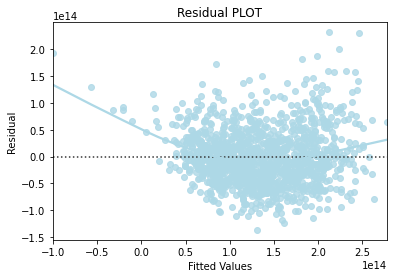

In [21]:
# predicted values
fitted = mreg.fittedvalues

# sns.set_style("whitegrid")
sns.residplot(x = fitted, y = residuals, color="lightblue", lowess=True)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

## Gaussian error

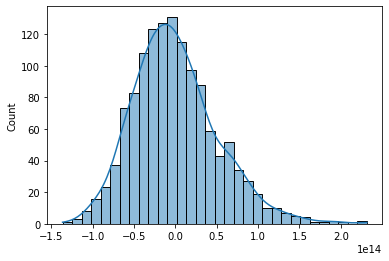

In [22]:
# Plot histogram of residuals
sns.histplot(residuals, kde=True)
plt.show()

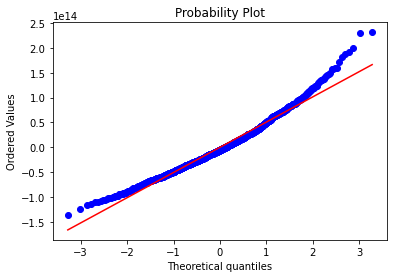

In [23]:
# Plot q-q plot of residuals
import pylab
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
plt.show()

In [26]:
#np.shape(DS_inner)
np.shape(acc_rate)

(4930,)

Text(0, 0.5, '$a_{\\rm 1/2}$')

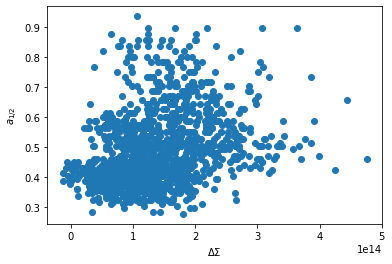

In [36]:
plt.scatter(DS_inner, cur_df.Halfmass_Scale)
plt.xlabel(r'$\Delta\Sigma$')
plt.ylabel(r'$a_{\rm 1/2}$')
#plt.xscale('log')

/global/homes/z/zzhang13/.conda/envs/myLSST/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


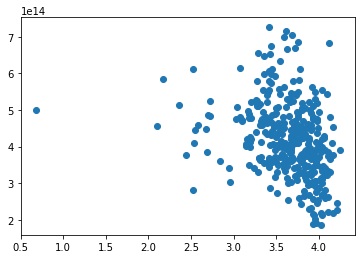

In [89]:
plt.scatter(np.log10(cur_df['Acc_Rate_2*Tdyn']), y) 
plt.show()

## Formation time alone

In [90]:
X_formation = cur_df[['Halfmass_Scale', 'T/|U|', 'c_vir', 'Acc_Rate_Mpeak']]


print(np.size(X))
print(np.size(y))

2202
367


In [91]:
X_formation = sm.add_constant(X_formation)
mreg_formation = sm.OLS(y, X_formation).fit()
display(mreg_formation.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     90.66
Date:                Wed, 07 Sep 2022   Prob (F-statistic):           2.56e-53
Time:                        09:36:04   Log-Likelihood:                -12229.
No. Observations:                 367   AIC:                         2.447e+04
Df Residuals:                     362   BIC:                         2.449e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.727e+14   4.96e+13      9.532      0.000    3.75e+14     5.7e+14
Halfmass_Scale -2.501e+14   5.69e+13     -4.397      0.000   -3.62e+14   -1.38e+14
T/|U|          -1.486e+14   7.57e+13     -1.963      0.050   -2.97e+14    2.37e+11
c_vir           2.566e+13    2.2e+12     11.647      0.000    2.13e+13       3e+13
Acc_Rate_Mpeak  6.622e+09   2.07e+09      3.204      0.001    2.56e+09    1.07e+10
==============================================================================
Omnibus:                       34.412   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.858
Skew:                           0.730   Prob(JB):                     4.94e-10
Kurtosis:                       3.820   Cond. No.                     1.50e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [92]:
ssr_formation = np.sum((mreg_formation.fittedvalues - np.mean(y))**2)
ssr_formation

1.8856662426228662e+30

## Mass alone

In [93]:
X_mass = cur_df[['logM']]

In [94]:
X_mass = sm.add_constant(X_mass)
mreg_mass = sm.OLS(y, X_mass).fit()
display(mreg_mass.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     10.56
Date:                Wed, 07 Sep 2022   Prob (F-statistic):            0.00126
Time:                        09:36:06   Log-Likelihood:                -12351.
No. Observations:                 367   AIC:                         2.471e+04
Df Residuals:                     365   BIC:                         2.471e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.948e+15   2.27e+15     -3.065      0.002   -1.14e+16   -2.49e+15
logM        6.448e+15   1.98e+15      3.250      0.001    2.55e+15    1.03e+16
==============================================================================
Omnibus:                        4.776   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.092   Jarque-Bera (JB):                4.517
Skew:                           0.258   Prob(JB):                        0.104
Kurtosis:                       3.173   Cond. No.                         875.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
ssr_mass = np.sum((mreg_mass.fittedvalues - np.mean(y))**2)
ssr_mass

1.0599131434567733e+29

## Partitioning Sum of Squares
* Total: 24.02
* SS Mass (unique): 24.02 - 14.66 = 9.36
* SS Formation time history (unique): 24.02 - 17.02 = 7.00
* SS Confounded: 7.66

## Testing the regression on the number count. 